# 実践課題：画像のデノイズ
### 1. 課題概要
画像のデノイズとは、ノイズが加わった画像を入力として、ノイズを除去したきれいな画像を出力するタスクです。この課題では、以下の手順で取り組みます。

ノイズ画像とクリーン画像のペアを用意。
シンプルな畳み込みニューラルネットワーク（CNN）を構築。
画像からノイズを除去するモデルを学習。

### ステップ1: データセットの準備
PyTorchのtorchvisionライブラリを使用してMNISTやCIFAR10データセットを利用できます。ノイズ画像を生成する方法は以下です：

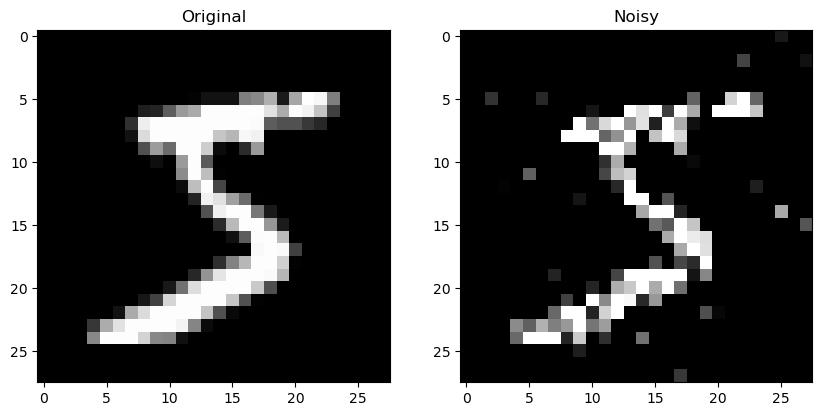

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# データ変換（Tensor化と正規化）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNISTデータセットをロード
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# ノイズ付きデータの生成
def add_noise(img, noise_factor=0.5):
    noise = noise_factor * torch.randn(img.size())
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

# サンプルデータで確認
import matplotlib.pyplot as plt
sample_img, _ = dataset[0]
noisy_img = add_noise(sample_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Noisy")
plt.imshow(noisy_img.squeeze(), cmap='gray')
plt.show()


### ステップ2: モデルの構築
シンプルなCNNを用いてデノイズを実現します。

In [2]:
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [1x28x28] -> [32x14x14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [32x14x14] -> [64x7x7]
            nn.ReLU()
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64x7x7] -> [32x14x14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32x14x14] -> [1x28x28]
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder()


### ステップ3: トレーニングループ
トレーニングデータを用いてモデルを学習します。

In [3]:
from torch.utils.data import DataLoader

# データローダーの準備
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 損失関数と最適化
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# トレーニングループ
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        # ノイズ付き画像と元画像を生成
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        
        # 損失計算とバックプロパゲーション
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.9251
Epoch [2/10], Loss: 0.9294
Epoch [3/10], Loss: 0.9236
Epoch [4/10], Loss: 0.9229
Epoch [5/10], Loss: 0.9288
Epoch [6/10], Loss: 0.9234
Epoch [7/10], Loss: 0.9208
Epoch [8/10], Loss: 0.9242
Epoch [9/10], Loss: 0.9253
Epoch [10/10], Loss: 0.9206


### ステップ4: テスト
モデルがノイズをどれだけ除去できたかを確認します。

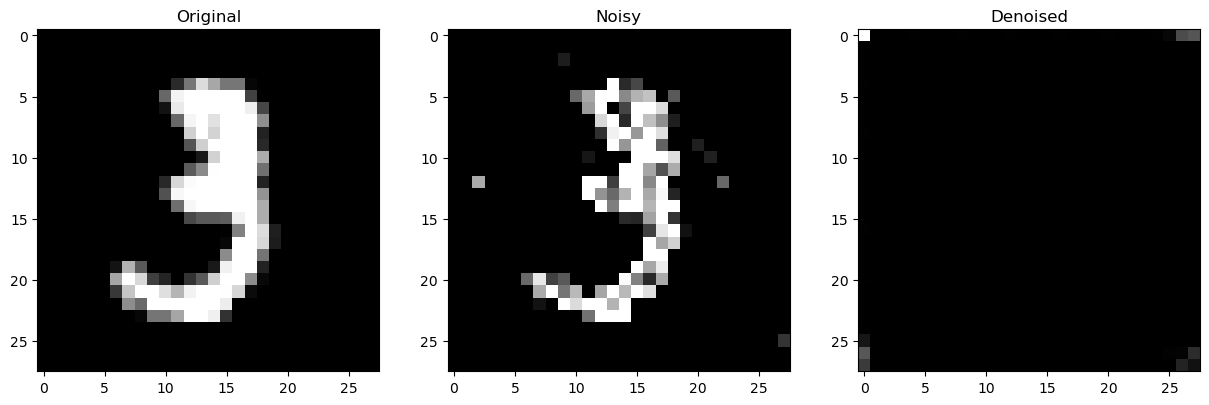

In [4]:
# テスト画像で確認
with torch.no_grad():
    sample_img, _ = dataset[10]
    noisy_sample = add_noise(sample_img.unsqueeze(0))
    denoised_img = model(noisy_sample)

# 可視化
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(sample_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Noisy")
plt.imshow(noisy_sample.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Denoised")
plt.imshow(denoised_img.squeeze(), cmap='gray')
plt.show()


### 課題のポイント
1. ノイズレベルの調整: noise_factor の値を変えて性能を比較してください。
2. モデルの改良:
- 畳み込み層を増やして性能を向上。
- 活性化関数を変更して試す（例: LeakyReLU）。
3. データ拡張: 入力画像に異なる種類のノイズ（ガウスノイズ、スパックルノイズなど）を追加。